In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
from matplotlib.pylab import plt
from numpy import arccos, array
from numpy.linalg import norm
import math
import cv2

from models.mtcnn import detect_faces, show_bboxes
from models.face_parsing import seg_faces

### Functions for fitting position

In [2]:
def getCenter(matrix):
    center_x = 0
    center_y = 0
    region = 0
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            if matrix[y][x]:
                center_x += x
                center_y += y
                region += 1
    
    if region == 0:
        center_x = -1.0
        center_y = -1.0
    else:
        center_x /= region
        center_y /= region
        
    return center_x, center_y

In [3]:
def getLandmarks(masks):
    landmarks = []
    for mask in masks:
        mask_leye = (mask == 4)
        mask_reye = (mask == 5)
        mask_nose = (mask == 10)
        mask_mouth = (mask == 11)
        mask_upper_lip = (mask == 12)
        mask_under_lip = (mask == 13)

        landmark = {}
        landmark["leye"]=np.array(getCenter(mask_leye))
        landmark["reye"]=np.array(getCenter(mask_reye))
        landmark["nose"]=np.array(getCenter(mask_nose))
        landmark["mouth"]=np.array(getCenter(mask_mouth))
        landmark["upper_lip"]=np.array(getCenter(mask_upper_lip))
        landmark["under_lip"]=np.array(getCenter(mask_under_lip))
        landmarks.append(landmark)
    
    return landmarks

In [4]:
def resizeLandmarks(landmarks, landmarks_size):
    for i, (landmark, landmark_size) in enumerate(zip(landmarks, landmarks_size)):
        for key in landmark.keys():
            landmark[key] *= np.array(landmark_size).astype(float) / 512.0
    return landmarks
        

In [5]:
def resizeMasks(masks, masks_size):
    newMasks = []
    for (mask, mask_size) in zip(masks, masks_size):
        mask = Image.fromarray(mask)
        mask = mask.resize(mask_size, resample=Image.BICUBIC)
        newMasks.append(np.asarray(mask))
    return newMasks
        

In [6]:
def theta(v, u): 
    v /= np.linalg.norm(v)
    u /= np.linalg.norm(u)
    angle = np.arccos(np.dot(v, u))
    return angle

def absolute(v):
    return math.sqrt(np.dot(v,v))

In [7]:
def getFaceDir(landmark):
    if landmark["under_lip"][0] > 0:
        vector = (landmark["leye"] + landmark["reye"])/2 - landmark["under_lip"]
    elif landmark["upper_lip"][0] > 0:
        vector = (landmark["leye"] + landmark["reye"])/2 - landmark["upper_lip"]
    elif landmark["mouth"][0] > 0:
        vector = (landmark["leye"] + landmark["reye"])/2 - landmark["mouth"]
    else:
        vector = (landmark["leye"] + landmark["reye"])/2 - landmark["nose"]
    return vector

In [34]:
def getRefinedMask(sourceImg, sourceMask, sourceLandmark, targetVector, target_size):
    sourceVector = getFaceDir(sourceLandmark)

    xc, yc = sourceLandmark["nose"].astype(int)
    h, w = sourceImg.size[:2]
    resize_ratio = target_size / np.array(sourceImg.size)
    
    # Rotate
    degree = -math.degrees(theta(sourceVector, targetVector))
    image = sourceImg.rotate(degree, resample=Image.BICUBIC, center=(xc, yc))
    mask = sourceMask.rotate(degree, resample=Image.BICUBIC, center=(xc, yc))
    
    # Crop and Resize
    nwr = int(min(image.size[0]-xc-1, xc-1))
    nhr = int(min(image.size[1]-yc-1, yc-1))
    image = image.crop((xc-nwr, yc-nhr, xc+nwr, yc+nhr))
    mask = mask.crop((xc-nwr, yc-nhr, xc+nwr, yc+nhr))

    image = image.resize(tuple((np.array(image.size) * resize_ratio).astype(int)))
    mask = mask.resize(tuple((np.array(mask.size) * resize_ratio).astype(int)))
    
    return image, mask

### 1. Source Image

In [35]:
# Get BBoxs
myimg_orig = Image.open('samples/v.jpg')
mybboxs, mylandmarks = detect_faces(myimg_orig)

# Convert to Nuki Boxs
mynboxs = []
for mybbox in mybboxs:
    x0, y0, x1, y1 = mybbox[:4]
    xc = (x0+x1)/2
    yc = (y0+y1)/2
    wr = (x1-x0)/2 * 2
    hr = (y1-y0)/2 * 2
    mynboxs.append((
        int(max(0,xc-wr)), 
        int(max(0,yc-hr*2)), 
        int(min(xc+wr, myimg_orig.size[0])), 
        int(min(yc+hr, myimg_orig.size[1]))))


w = mynboxs[0][2] - mynboxs[0][0]
h = mynboxs[0][3] - mynboxs[0][1]
mymasks_all = np.array(seg_faces(myimg_orig, mynboxs))
mymasks = (mymasks_all > 0) & (mymasks_all != 14) & (mymasks_all != 16)
mymasks = resizeMasks(mymasks, [(w,h)])
mylandmarks = getLandmarks(mymasks_all)
mylandmarks = resizeLandmarks(mylandmarks, [(w,h)])

# Source Info
mymask = Image.fromarray(mymasks[0])
myimg = myimg_orig.crop(tuple(mynboxs[0])).resize((mymask.size))
mylandmark = mylandmarks[0]


In [36]:
mylandmark

{'leye': array([263.36833244, 376.8591505 ]),
 'reye': array([341.70595772, 366.07481785]),
 'nose': array([340.40633521, 412.69480989]),
 'mouth': array([-1.22851562, -1.52539062]),
 'upper_lip': array([351.0544961 , 502.15757456]),
 'under_lip': array([356.28564699, 519.35779634])}

### 2. Target Image

In [37]:
# img = Image.open('samples/trot.png')
# Image.fromarray(np.asarray(img)[:,:,:3]).save("samples/trot.jpg")

In [38]:
# Get BBoxs
img = Image.open('samples/jbg.jpg')
bboxs, landmarks = detect_faces(img)

# Convert to Nuki Boxs
nboxs = []
for bbox in bboxs:
    x0, y0, x1, y1 = bbox[:4]
    xc = (x0+x1)/2
    yc = (y0+y1)/2
    wr = (x1-x0)/2 * 2
    hr = (y1-y0)/2 * 2
    nboxs.append((
        int(max(0, xc-wr)), 
        int(max(0, yc-hr)), 
        int(min(xc+wr, img.size[0])), 
        int(min(yc+hr, img.size[1]))
    ))
    
sizes = [(nb[2]-nb[0], nb[3]-nb[1]) for nb in nboxs]
masks_all = np.array(seg_faces(img, nboxs))
masks = (masks_all > 0) & (masks_all != 14) & (masks_all != 16)
masks = resizeMasks(masks, sizes)
landmarks = getLandmarks(masks_all)
landmarks = resizeLandmarks(landmarks, sizes)

### 3. Replace Face

In [39]:
my_img = np.asarray(myimg)
orig_img = np.asarray(img)
result_img = np.asarray(img).copy()

zip_list = zip(nboxs, masks, landmarks)
zip_list = sorted(zip_list, key=lambda x : x[1].sum())
for nbox, mask, landmark in zip_list:
    
    # Target Face Region
    xc, yc = nbox[:2]+landmark["nose"].astype(int)
    w = nbox[2]-nbox[0]
    h = nbox[3]-nbox[1]
    targetVector = getFaceDir(landmark)
    
    # Change Source Face Angle, Size
    face_img, face_mask = getRefinedMask(myimg, mymask, mylandmark, targetVector, (w,h))
    
    # Adjust Mask
    face_img = np.asarray(face_img).copy()
    face_mask = np.asarray(face_mask)
    face_mask = np.expand_dims(face_mask, 2)
    face_img *= face_mask
    
    
    # Sticker Source Image to Target Region
    for y in range(face_img.shape[0]):
        ny = yc - int(face_img.shape[0]/2) + y
        if ny < 0 or ny >= result_img.shape[0]:
            continue
        for x in range(face_img.shape[1]):
            nx = xc - int(face_img.shape[1]/2) + x
            if nx < 0 or nx >= result_img.shape[1]:
                continue
            
            if np.sum(face_img[y][x]) == 0:
                continue
            result_img[ny][nx] = face_img[y][x]


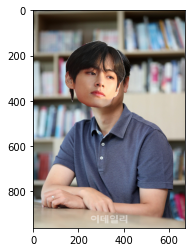

In [40]:
plt.imshow(result_img)
Image.fromarray(result_img).save("results/result_replace_seg.jpg")

- 0: background   
- 1: face   
- 2: left eyebrow
- 3: right eyebrow
- 4: 왼쪽눈?
- 5: 오른쪽눈?
- 6: glasses 
- 7: left ear   
- 8: right ear   
- 9: 귀걸이??
- 10: nose   
- 11: mouth   
- 12: upper lip  
- 13: under lip
- 14: neck   
- 15: 목걸이??
- 16: shoulder
- 17: hair   
